# ENAS: Efficient Neural Architecture Search via Parameter Sharing

Implement ENAS for CIFAR-10 dataset. Compare with random structure selection. Model: 3-layer network. Structure: binary mask for each parameter. Plots: model peformance, mask.






$\textbf{Training the shared parameters } \omega \textbf{ of the child models.}$ (= DynamicMLP)
In this step, we fix the controller’s policy $\pi(m;\theta)$ and perform stochastic gradient descent (SGD) on $\omega$ to minimize the expected loss function $\mathbb{E}_{m\sim\pi(m;\theta)} [L(m;\omega)]$. Here, $L(m;\omega)$ is the standard cross-entropy loss, computed on a minibatch of training data, with a model $m$ sampled from $\pi(m;\theta)$. The gradient is computed using the Monte Carlo estimate

\begin{equation}
\nabla_{\omega} \mathbb{E}_{m\sim\pi(m;\theta)} [L(m;\omega)] \approx \frac{1}{M} \sum_{i=1}^{M} \nabla_{\omega} L(m_i;\omega), \quad (1)
\end{equation}

where $m_i$'s are sampled from $\pi(m;\theta)$ (controller) as described above. Eqn 1 provides an unbiased estimate of the gradient $\nabla_{\omega} \mathbb{E}_{m\sim\pi(m;\theta)} [L(m;\omega)]$. However, this estimate has a higher variance than the standard SGD gradient, where $m$ is fixed. Nevertheless – and this is perhaps surprising – we find that **$M = 1$ works just fine, i.e. we can update $\omega$ using the gradient from any \textit{single} model $m$ sampled from $\pi(m;\theta)$**. As mentioned, we train $\omega$ during a entire pass through the training data.




$\textbf{Training the controller parameters } \theta$ (= LSTM). In this step, we fix $\omega$ (DynamicMLP in my case) and update the policy parameters $\theta$ (controller), aiming to maximize the expected reward $\mathbb{E}_{m\sim\pi(m;\theta)} [R(m,\omega)]$. We employ the Adam optimizer, for which the gradient is computed using **REINFORCE algorithm** (Williams, 1992).

The reward $R(m,\omega)$ is computed on the validation set, rather than on the training set, to encourage ENAS to select models that generalize well rather than models that overfit the training set well. In our language model experiment, the reward function is $\frac{C}{\text{valid_ppl}}$, where the perplexity is computed on a minibatch of validation data. **In our image classification experiments, the reward function is the accuracy on a minibatch of validation images.**


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn.functional as F


class DynamicMLP(nn.Module):
    def __init__(self, input_dim, max_layer1_neurons, max_layer2_neurons, output_dim):
        super(DynamicMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, max_layer1_neurons)
        self.fc2 = nn.Linear(max_layer1_neurons, max_layer2_neurons)
        self.fc3 = nn.Linear(max_layer2_neurons, output_dim)
        self.mask_layer1 = None
        self.mask_layer2 = None

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, input_dim)))
        x = x * self.mask_layer1.expand_as(x)
        x = F.relu(self.fc2(x))
        x = x * self.mask_layer2.expand_as(x)
        x = self.fc3(x)
        return x

    def apply_mask(self, mask_layer1, mask_layer2):
        self.mask_layer1 = mask_layer1
        self.mask_layer2 = mask_layer2

In [3]:
class Controller(nn.Module):
    def __init__(self, max_layer1_neurons, max_layer2_neurons, hidden_dim, num_layers):
        super(Controller, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=3 * 32 * 32, hidden_size=hidden_dim, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, max_layer1_neurons + max_layer2_neurons)
        self.log_probs = None

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)

        out, (h_n, c_n) = self.lstm(x.view(batch_size, -1).unsqueeze(0), (h_0, c_0))
        mask_logits = self.fc(h_n[-1])

        mask_logits_layer1 = mask_logits[:, :max_layer1_neurons]
        mask_logits_layer2 = mask_logits[:, max_layer1_neurons:max_layer1_neurons + max_layer2_neurons]
        mask_layer1 = torch.sigmoid(mask_logits_layer1).mean(0) > 0.5
        mask_layer2 = torch.sigmoid(mask_logits_layer2).mean(0) > 0.5

        return mask_layer1.float(), mask_layer2.float(), mask_logits

    def sample_masks(self):
        # Не очень понял из статьи как ENAS сэмплирует архитектуру на инференсе
        # решил подавать рандомный вход
        # пробовал torch.zeros, отличия в экспериментах не заметил
        x = torch.rand(1, 1, 3 * 32 * 32)
        mask_layer1, mask_layer2, log_probs = self.forward(x)
        self.log_probs = log_probs
        return mask_layer1, mask_layer2

In [4]:
def train_shared_child_parameters(controller, mlp_model, trainloader, optimizer):
    mlp_model.train()
    for inputs, targets in trainloader:
        optimizer.zero_grad()

        inputs = inputs.view(-1, 3 * 32 * 32)
        mask_layer1, mask_layer2, _ = controller.forward(inputs)

        mlp_model.apply_mask(mask_layer1, mask_layer2)
        outputs = mlp_model(inputs)
        loss = F.cross_entropy(outputs, targets)

        loss.backward()
        optimizer.step()
    return loss.item()

In [5]:
def evaluate(model, testloader):
    model.eval()
    accuracy = 0
    total = 0

    with torch.no_grad():
        for x, y in testloader:
            output = model(x)
            _, predicted = torch.max(output, 1)
            total += y.size(0)
            accuracy += (predicted == y).sum().item()

    return accuracy / total

In [10]:
def train(controller, mlp_model, optimizer_mlp, optimizer_controller, trainloader, testloader, num_epochs, num_layers):
    metrics = {'loss': [], 'reward': []}
    for epoch in range(num_epochs):

        # Train DynamicMLP
        train_loss = train_shared_child_parameters(controller, mlp_model, trainloader, optimizer_mlp)

        # Train Controller using REINFORCE
        optimizer_controller.zero_grad()
        mask_layer1, mask_layer2 = controller.sample_masks()
        mlp_model.apply_mask(mask_layer1, mask_layer2)

        reward = evaluate(mlp_model, testloader) # = Accuracy

        policy_loss = [-log_prob * reward for log_prob in controller.log_probs]
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        optimizer_controller.step()

        metrics['loss'].append(train_loss)
        metrics['reward'].append(reward)
        print(f'Epoch {epoch+1}, Total Loss: {train_loss:.6f}, Total Reward(Accuracy): {reward:.6f}')
    return metrics

In [21]:
input_dim = 3072  # Размер входных данных CIFAR-10
hidden_dim = 100  # Размер скрытого слоя LSTM
num_layers = 5  # Число слоев в LSTM
output_dim = 10  # Количество классов в CIFAR-10
max_layer1_neurons = 400
max_layer2_neurons = 100


controller = Controller(max_layer1_neurons, max_layer2_neurons, hidden_dim, num_layers)
mlp_model = DynamicMLP(input_dim, max_layer1_neurons, max_layer2_neurons, output_dim)
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
optimizer_controller = optim.Adam(controller.parameters(), lr=0.001)


metrics = train(
    controller, mlp_model, optimizer_mlp, optimizer_controller,
    trainloader, testloader, num_epochs=20, num_layers=5
)

Epoch 1, Total Loss: 1.564681, Total Reward(Accuracy): 0.460600
Epoch 2, Total Loss: 1.339337, Total Reward(Accuracy): 0.501500
Epoch 3, Total Loss: 1.322967, Total Reward(Accuracy): 0.509300
Epoch 4, Total Loss: 1.317593, Total Reward(Accuracy): 0.516700
Epoch 5, Total Loss: 1.205146, Total Reward(Accuracy): 0.518200
Epoch 6, Total Loss: 1.262240, Total Reward(Accuracy): 0.524900
Epoch 7, Total Loss: 1.435195, Total Reward(Accuracy): 0.530600
Epoch 8, Total Loss: 0.777352, Total Reward(Accuracy): 0.527000
Epoch 9, Total Loss: 1.247403, Total Reward(Accuracy): 0.536100
Epoch 10, Total Loss: 1.017258, Total Reward(Accuracy): 0.537800
Epoch 11, Total Loss: 0.883572, Total Reward(Accuracy): 0.527000
Epoch 12, Total Loss: 0.979680, Total Reward(Accuracy): 0.528100
Epoch 13, Total Loss: 0.942416, Total Reward(Accuracy): 0.526900
Epoch 14, Total Loss: 0.750811, Total Reward(Accuracy): 0.537900
Epoch 15, Total Loss: 0.657746, Total Reward(Accuracy): 0.524000
Epoch 16, Total Loss: 0.584060, To

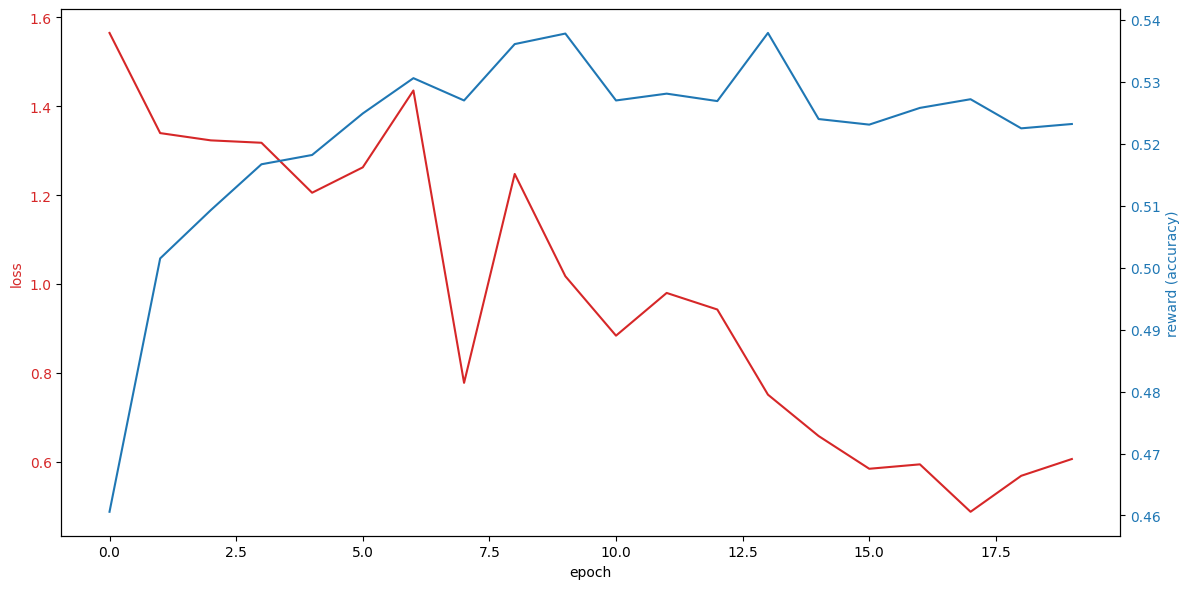

In [22]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color=color)
ax1.plot(metrics['loss'], color=color, label='loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('reward (accuracy)', color=color)
ax2.plot(metrics['reward'], color=color, label='reward (accuracy)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In [13]:
from tqdm import trange

def RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons):
    mask_layer1 = torch.rand(max_layer1_neurons) > 0.5
    mask_layer2 = torch.rand(max_layer2_neurons) > 0.5
    return mask_layer1.float(), mask_layer2.float()

rnd_mlp_model = DynamicMLP(input_dim, max_layer1_neurons, max_layer2_neurons, output_dim)
num_iterations = 50

best_reward = -float('inf')
best_mask = RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons)

for i in trange(num_iterations):
    mask_layer1, mask_layer2 = RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons)

    rnd_mlp_model.apply_mask(mask_layer1, mask_layer2)
    reward = evaluate(rnd_mlp_model, testloader)

    if reward > best_reward:
        best_reward = reward
        best_mask = mask_layer1, mask_layer2
        print(f"New Best Reward(Accuracy): {best_reward:.6f}")

rnd_mlp_model.apply_mask(*best_mask)

  2%|▏         | 1/50 [00:03<02:52,  3.52s/it]

New Best Reward(Accuracy): 0.101300


  6%|▌         | 3/50 [00:11<02:56,  3.75s/it]

New Best Reward(Accuracy): 0.102500


 18%|█▊        | 9/50 [00:33<02:37,  3.84s/it]

New Best Reward(Accuracy): 0.104300


 20%|██        | 10/50 [00:37<02:30,  3.76s/it]

New Best Reward(Accuracy): 0.111500


 22%|██▏       | 11/50 [00:41<02:33,  3.94s/it]

New Best Reward(Accuracy): 0.114100


 42%|████▏     | 21/50 [01:29<02:11,  4.55s/it]

New Best Reward(Accuracy): 0.121300


 74%|███████▍  | 37/50 [02:33<00:49,  3.84s/it]

New Best Reward(Accuracy): 0.123200


100%|██████████| 50/50 [03:24<00:00,  4.09s/it]


Видим, что RandomSelectionSearch не может получить модель с reward(accuracy) выше 0.13, в отличие от ENAS, который получает модель с accuracy примерно 0.5 уже после первой эпохи

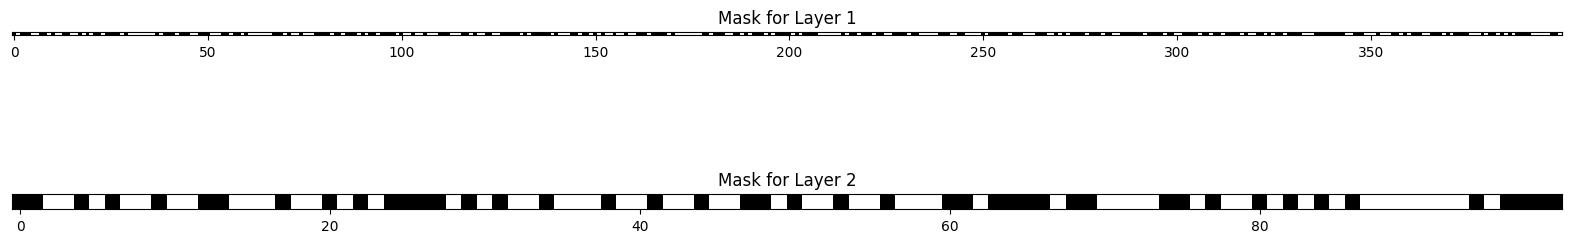

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_masks(mask_layer1, mask_layer2):
    mask_layer1_np = mask_layer1.cpu().numpy()
    mask_layer2_np = mask_layer2.cpu().numpy()

    # Визуализация маски для слоя 1
    plt.figure(figsize=(20, 4))
    plt.subplot(2, 1, 1)
    plt.imshow(mask_layer1_np[np.newaxis, :], cmap='binary')
    plt.title("Mask for Layer 1")
    plt.yticks([])

    # Визуализация маски для слоя 2
    plt.subplot(2, 1, 2)
    plt.imshow(mask_layer2_np[np.newaxis, :], cmap='binary')
    plt.title("Mask for Layer 2")
    plt.yticks([])

    plt.show()

visualize_masks(mlp_model.mask_layer1, mlp_model.mask_layer2)

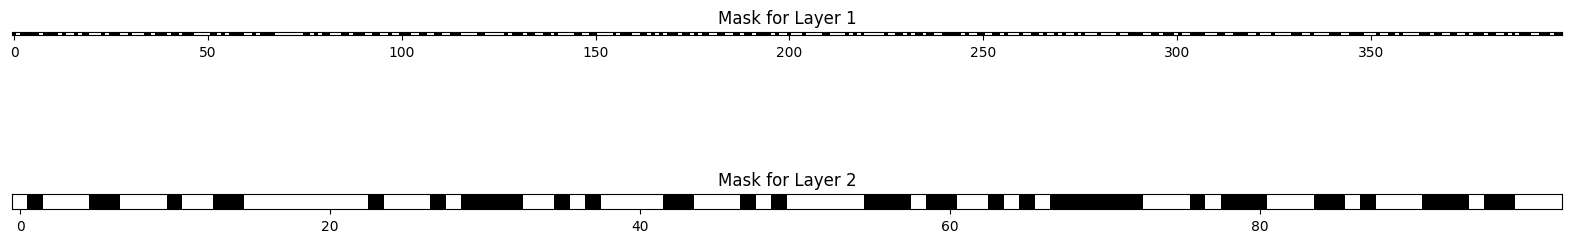

In [15]:
# best_mask -- лучшие маски для RandomSelectionSearch
visualize_masks(*best_mask)


- **ENAS Accuracy**: **0.523**.
- **Random Selection Accuracy**: **0.123**.
- Результаты ENAS не прям вау, возможно, стоит больше упереться в поиск оптимальных гиперпараметров

**Conclusion**: ENAS shows promise with superior results to random selection but requires further hyperparameter optimization.